In [156]:
# %%
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')


## Utility Functions

In [1]:
def get_features_datetime(df):
    """
    Generating time series features based on date and time
    """
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df


def get_lagged_values(df, col_name='PJMW_MW', num_lags=24):
	"""
	Generating lagged values of the target
	"""
	for i in range(1, num_lags+1, 1):
		var_name = f'{col_name}(t-{i})'
		df[var_name] = df[col_name].shift(i)
	
	return df

## Load Data

In [157]:
# read data
df = pd.read_csv('PJMW_hourly.csv')
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)
df_org = df.copy()
df.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


<AxesSubplot: title={'center': 'PJME Energy Usage in MW'}, xlabel='Datetime'>

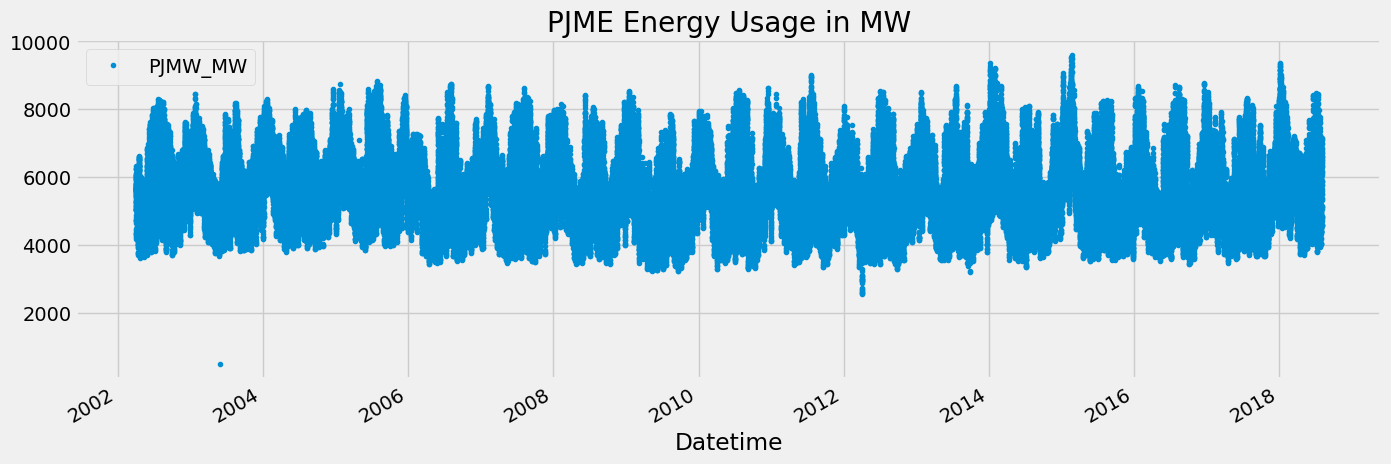

In [158]:
# split data
df.plot(style='.', figsize=(15, 5), title='PJME Energy Usage in MW')

## Train/Test Split

C:\Users\abbas\AppData\Local\Temp\ipykernel_9060\4213474168.py:12: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax.legend('Train Set', 'Test Set')


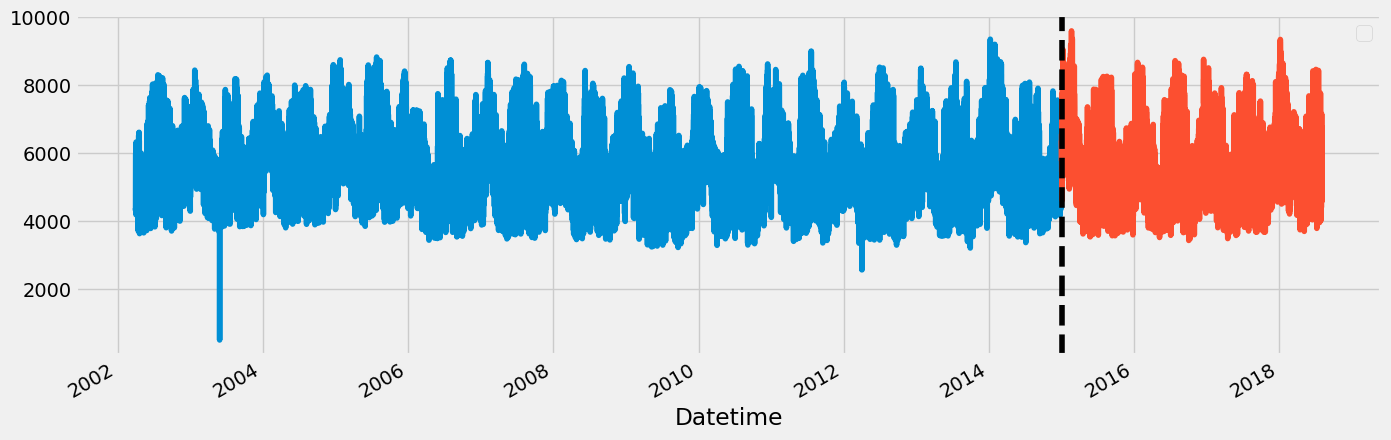

In [159]:
split_date = '01-01-2015'
train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Train')
test.plot(ax=ax, label='Test')
ax.axvline(split_date, color='black', ls='--')
ax.legend('Train Set', 'Test Set')
plt.show()

<AxesSubplot: title={'center': 'One Week of Data'}, xlabel='Datetime'>

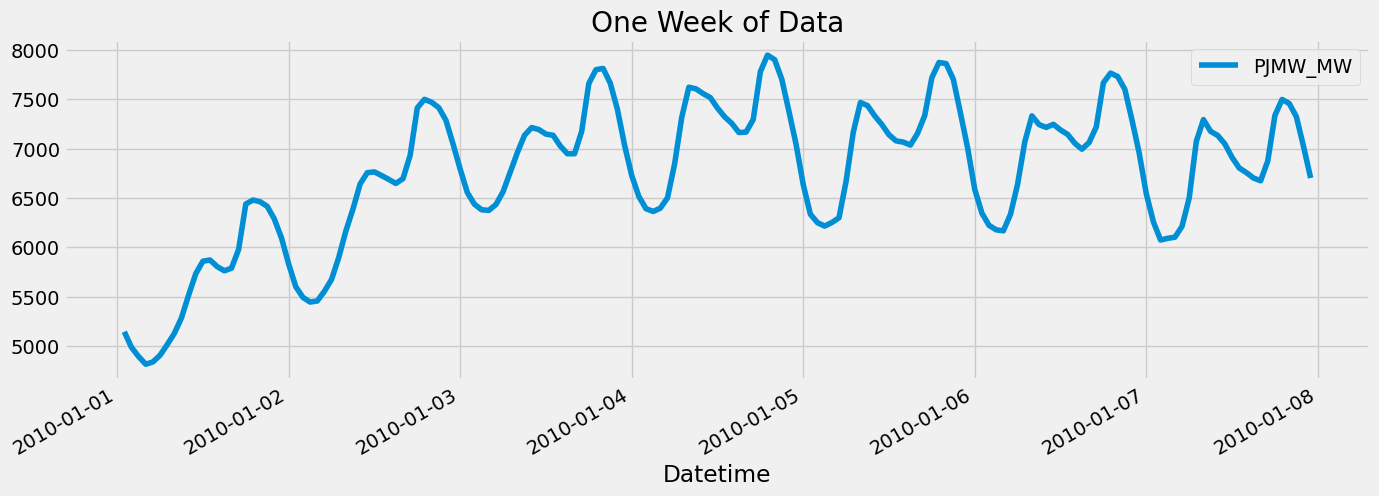

In [160]:
# one week data
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5), title='One Week of Data')

## Feature Engineering

In [162]:
df = get_features_datetime(df)
# df = get_lagged_values(df)
df.head()

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,5077.0,1,1,4,12,2002,365
2002-12-31 02:00:00,4939.0,2,1,4,12,2002,365
2002-12-31 03:00:00,4885.0,3,1,4,12,2002,365
2002-12-31 04:00:00,4857.0,4,1,4,12,2002,365
2002-12-31 05:00:00,4930.0,5,1,4,12,2002,365


## Visualise Features

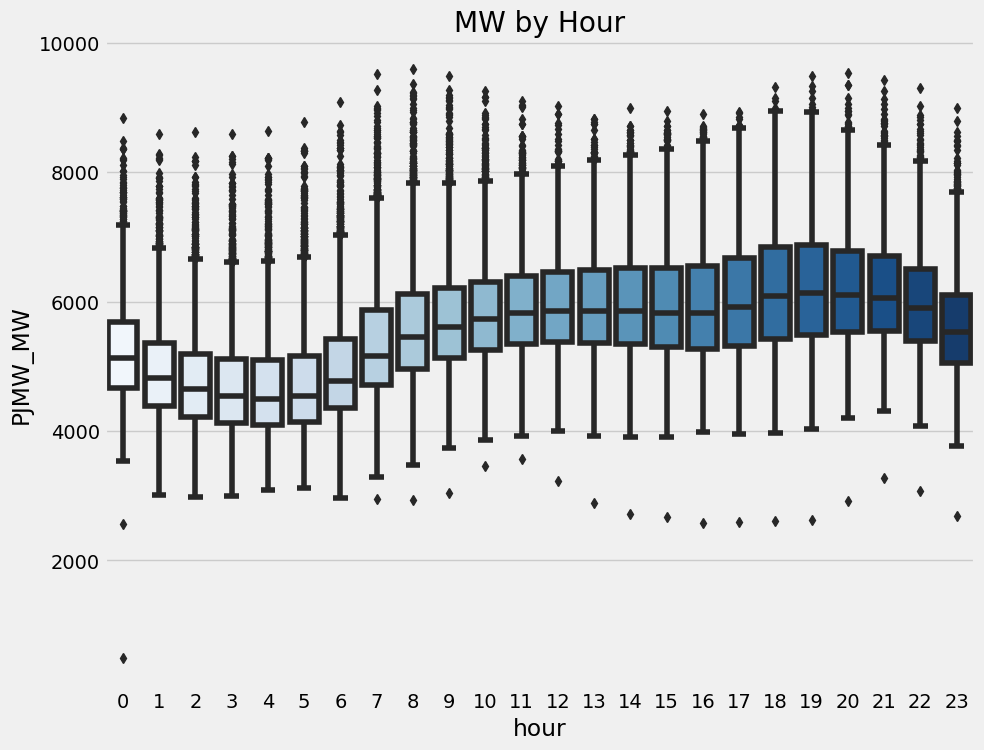

In [163]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJMW_MW', palette='Blues')
ax.set_title('MW by Hour')
plt.show()

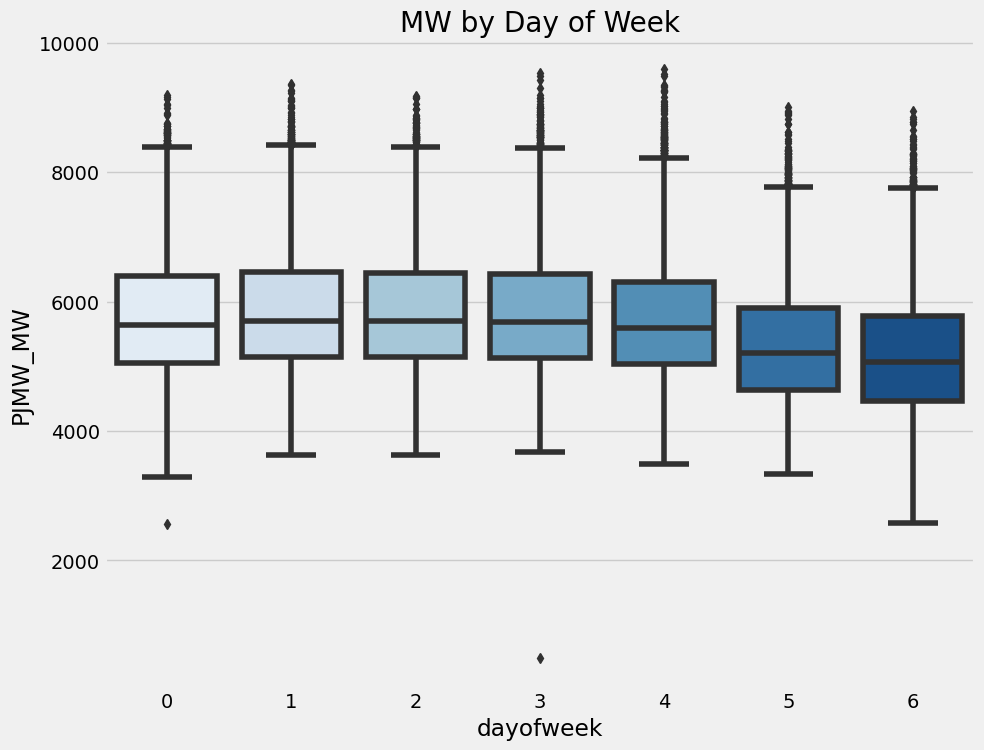

In [164]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='PJMW_MW', palette='Blues')
ax.set_title('MW by Day of Week')
plt.show()

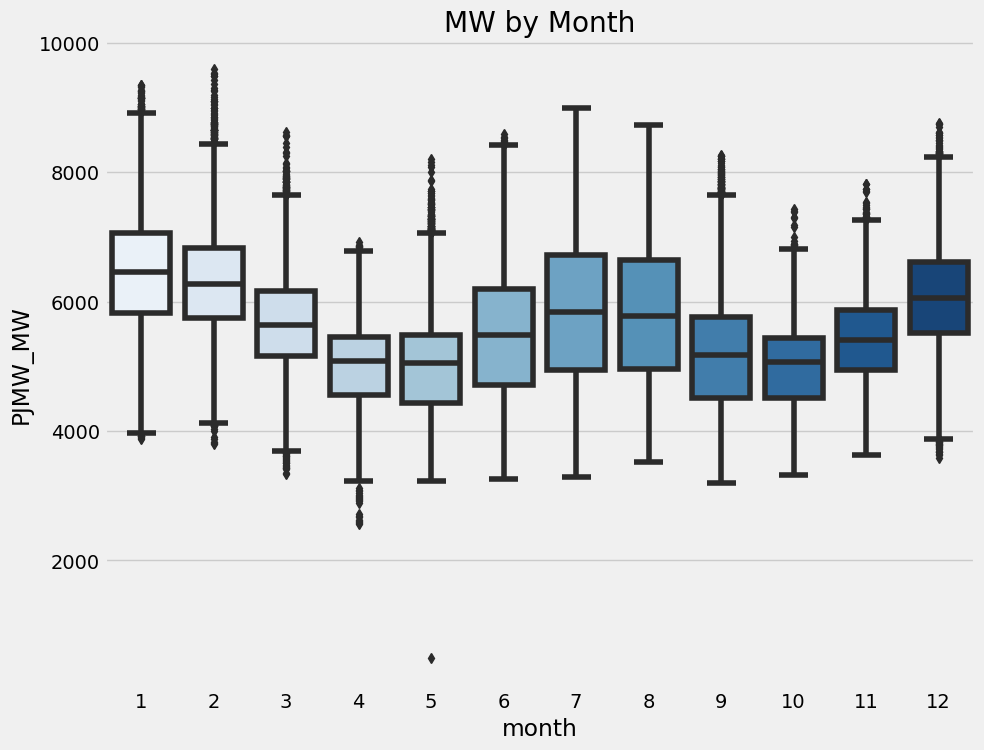

In [165]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJMW_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# XGBoost Model

## <font color='orange'> Using Date and Time Features </font>

In [166]:
df_train = df.loc[df.index < split_date]
df_test = df.loc[df.index >= split_date]

In [167]:
X_train = df_train.loc[:, df_train.columns != 'PJMW_MW']
y_train = df_train['PJMW_MW']

X_test = df_test.loc[:, df_test.columns != 'PJMW_MW']
y_test = df_test['PJMW_MW']

In [168]:
from tabnanny import verbose

reg = xgb.XGBRegressor(n_estimators=400)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 100,
        verbose=100
        )

[0]	validation_0-rmse:3999.02997	validation_1-rmse:4006.16695


c:\Users\abbas\Desktop\myfiles\Git_Repos\xgb_ts\env_new\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:268.59609	validation_1-rmse:734.65606
[111]	validation_0-rmse:260.41231	validation_1-rmse:736.74064


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot: title={'center': 'Feature Importance'}>

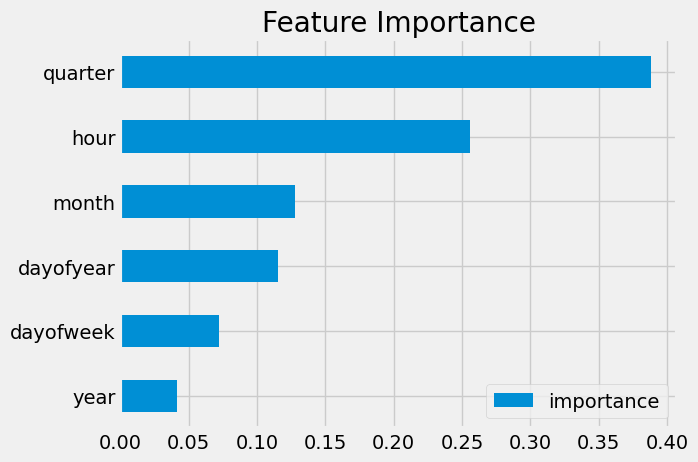

In [169]:
df_fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
df_fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

### <font color='orange'>Test Set Predictions </font>

C:\Users\abbas\AppData\Local\Temp\ipykernel_9060\1877736558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['MW_Prediction'] = reg.predict(X_test)


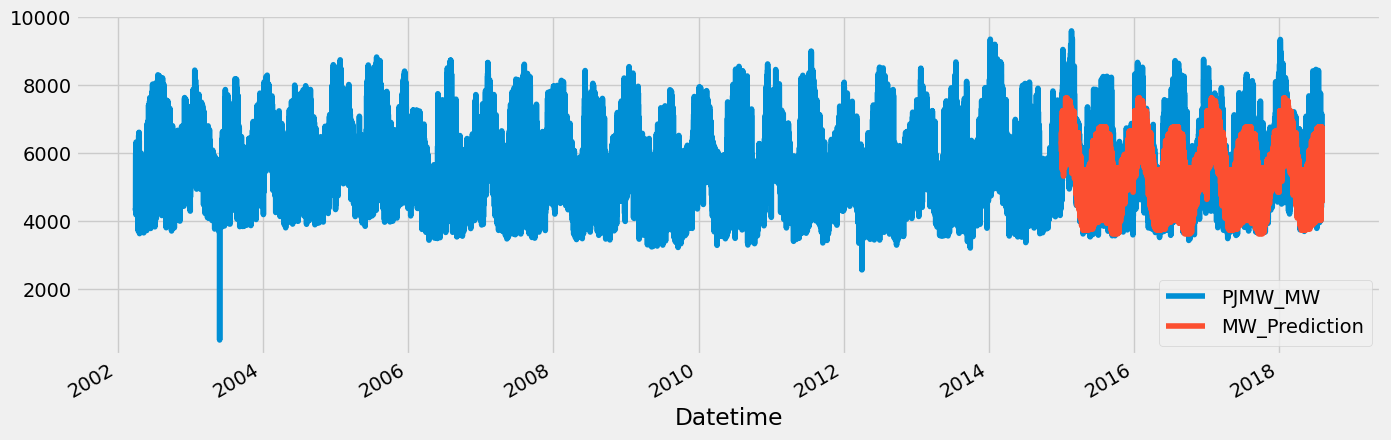

In [170]:
# prediction for the test set
df_test['MW_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_train, df_test], sort=False)
# plot all data (predictions and actuals)
_ = df_all[['PJMW_MW', 'MW_Prediction']].plot(figsize=(15,5))

In [171]:
def mape(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100
mape(y_true = df_all['PJMW_MW'], y_pred = df_all['MW_Prediction'])

8.414898791740782

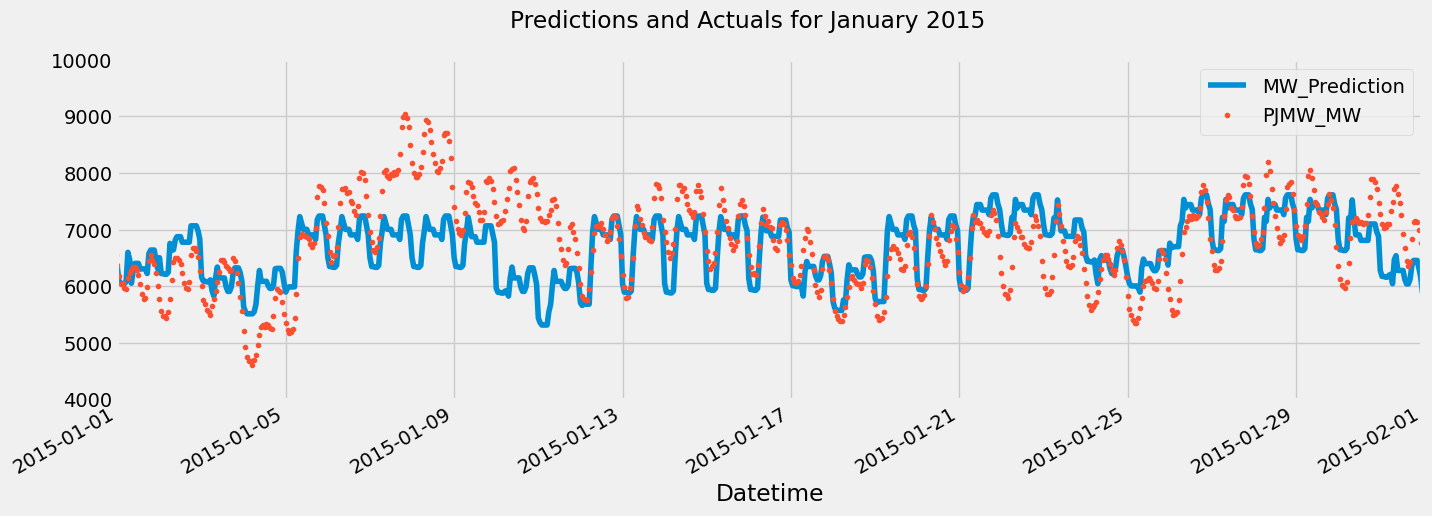

In [172]:
fig, ax = plt.subplots(1)
fig.set_figwidth(15)
fig.set_figheight(5)
_ = df_all[['MW_Prediction', 'PJMW_MW']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(4000, 10000)
plot = plt.suptitle('Predictions and Actuals for January 2015')

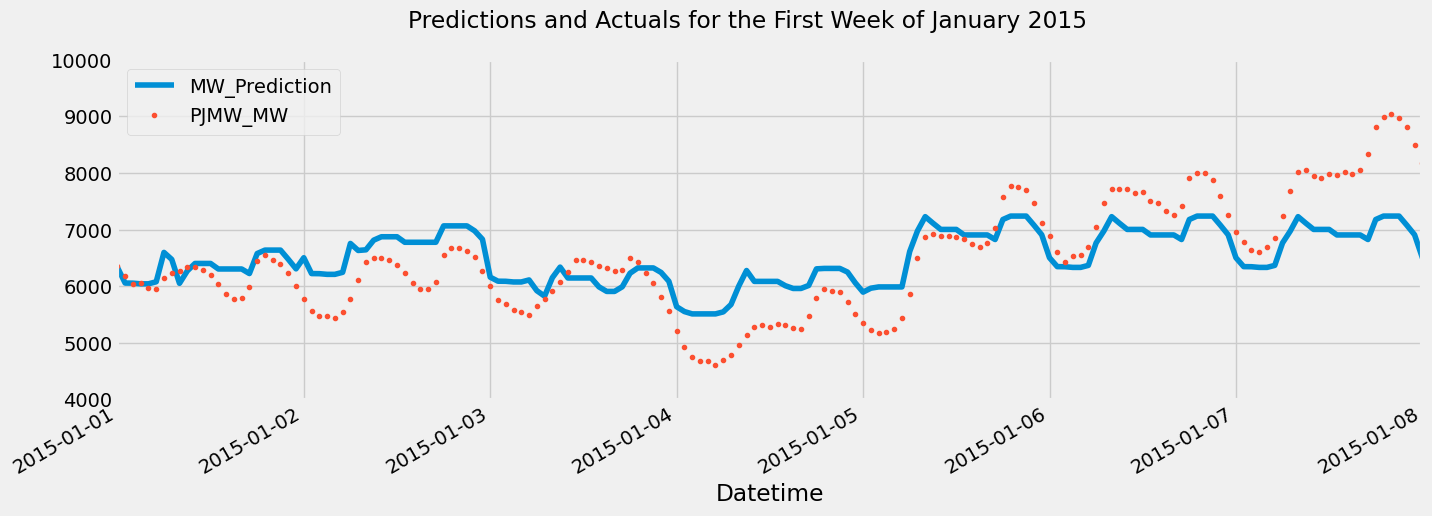

In [173]:
fig, ax = plt.subplots(1)
fig.set_figwidth(15)
fig.set_figheight(5)
_ = df_all[['MW_Prediction', 'PJMW_MW']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(4000, 10000)
plot = plt.suptitle('Predictions and Actuals for the First Week of January 2015')

## <font color='green'> Using All Features </font>
* Date and Time Features
* Historical data

In [184]:
df_all_features = get_features_datetime(df_org)
df_all_features = get_lagged_values(df_all_features)

# drop rows with NaN values due to the shift
df_all_features = df_all_features[df_all_features['PJMW_MW(t-24)'].notna()]

df_all_features.head()

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,PJMW_MW(t-1),PJMW_MW(t-2),PJMW_MW(t-3),...,PJMW_MW(t-15),PJMW_MW(t-16),PJMW_MW(t-17),PJMW_MW(t-18),PJMW_MW(t-19),PJMW_MW(t-20),PJMW_MW(t-21),PJMW_MW(t-22),PJMW_MW(t-23),PJMW_MW(t-24)
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-12-30 01:00:00,5340.0,1,0,4,12,2002,364,4931.0,5143.0,5358.0,...,6019.0,5962.0,5824.0,5493.0,5126.0,4930.0,4857.0,4885.0,4939.0,5077.0
2002-12-30 02:00:00,5225.0,2,0,4,12,2002,364,5340.0,4931.0,5143.0,...,5988.0,6019.0,5962.0,5824.0,5493.0,5126.0,4930.0,4857.0,4885.0,4939.0
2002-12-30 03:00:00,5317.0,3,0,4,12,2002,364,5225.0,5340.0,4931.0,...,5885.0,5988.0,6019.0,5962.0,5824.0,5493.0,5126.0,4930.0,4857.0,4885.0
2002-12-30 04:00:00,5310.0,4,0,4,12,2002,364,5317.0,5225.0,5340.0,...,5764.0,5885.0,5988.0,6019.0,5962.0,5824.0,5493.0,5126.0,4930.0,4857.0
2002-12-30 05:00:00,5403.0,5,0,4,12,2002,364,5310.0,5317.0,5225.0,...,5612.0,5764.0,5885.0,5988.0,6019.0,5962.0,5824.0,5493.0,5126.0,4930.0


In [185]:
df_train = df_all_features.loc[df_all_features.index < split_date]
df_test = df_all_features.loc[df_all_features.index >= split_date]


X_train = df_train.loc[:, df_train.columns != 'PJMW_MW']
y_train = df_train['PJMW_MW']

X_test = df_test.loc[:, df_test.columns != 'PJMW_MW']
y_test = df_test['PJMW_MW']

from tabnanny import verbose

reg = xgb.XGBRegressor(n_estimators=400)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 100,
        verbose=100
        )

[0]	validation_0-rmse:3980.20675	validation_1-rmse:3997.12264


c:\Users\abbas\Desktop\myfiles\Git_Repos\xgb_ts\env_new\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:79.46849	validation_1-rmse:114.72333
[200]	validation_0-rmse:67.85904	validation_1-rmse:112.83205
[300]	validation_0-rmse:59.68343	validation_1-rmse:112.16125
[399]	validation_0-rmse:54.32174	validation_1-rmse:111.96171


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot: title={'center': 'Feature Importance'}>

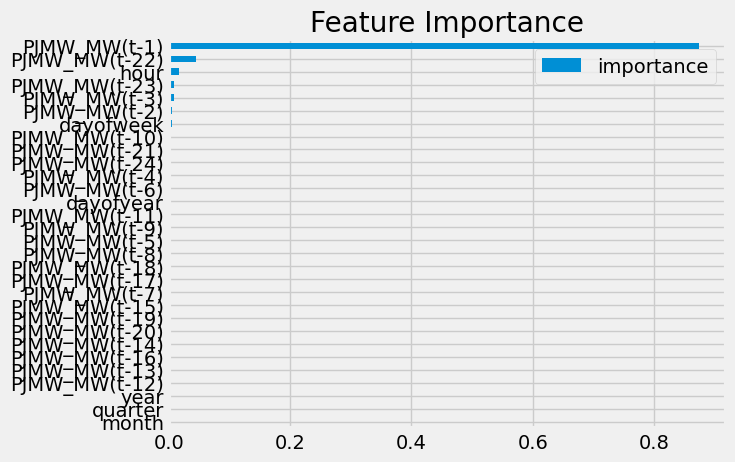

In [186]:
df_fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
df_fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

### <font color='green'>Test Set Predictions </font>

C:\Users\abbas\AppData\Local\Temp\ipykernel_9060\1877736558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['MW_Prediction'] = reg.predict(X_test)


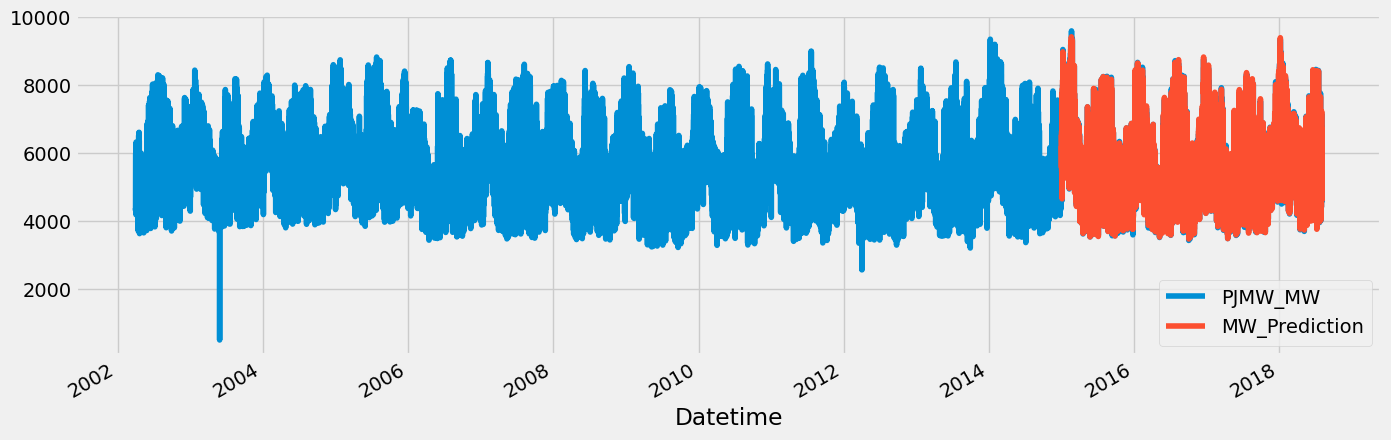

In [188]:
# prediction for the test set
df_test['MW_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_train, df_test], sort=False)
# plot all data (predictions and actuals)
_ = df_all[['PJMW_MW', 'MW_Prediction']].plot(figsize=(15,5))

In [189]:
# Forecasting error
mape(y_true = df_all['PJMW_MW'], y_pred = df_all['MW_Prediction'])

1.2014455230155507

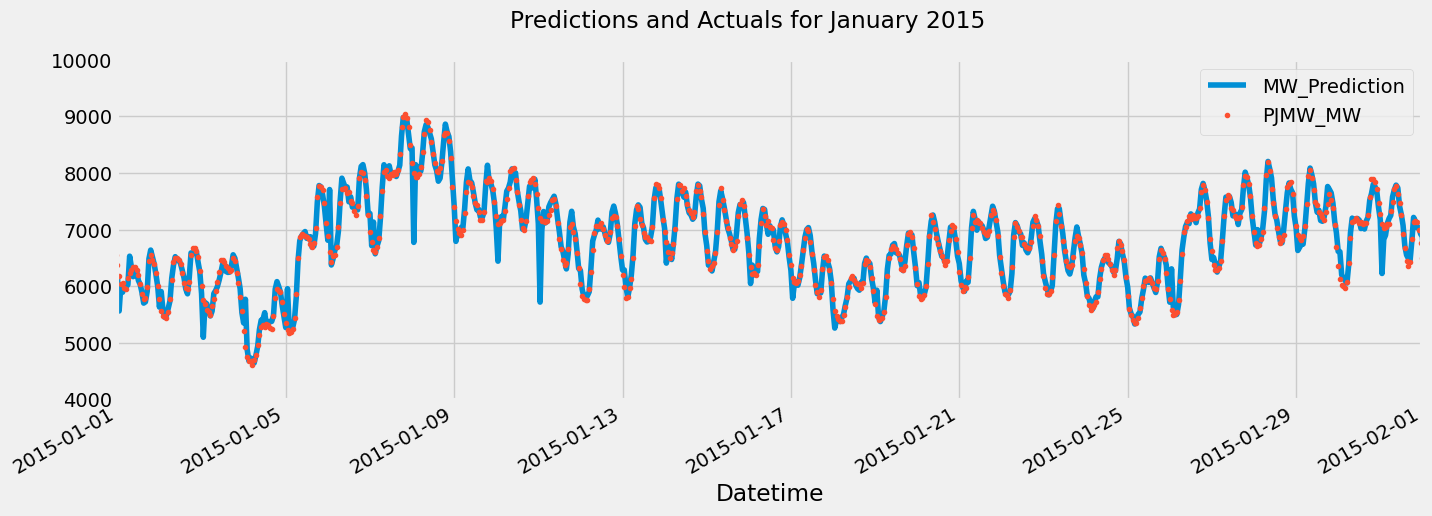

In [190]:
fig, ax = plt.subplots(1)
fig.set_figwidth(15)
fig.set_figheight(5)
_ = df_all[['MW_Prediction', 'PJMW_MW']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(4000, 10000)
plot = plt.suptitle('Predictions and Actuals for January 2015')

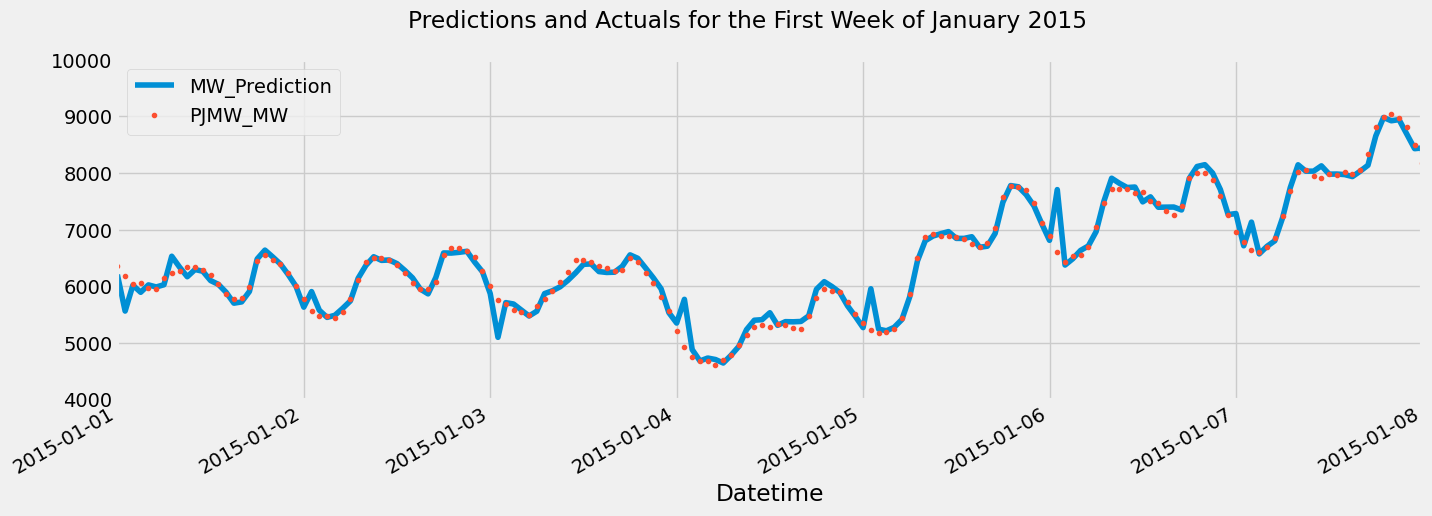

In [191]:
fig, ax = plt.subplots(1)
fig.set_figwidth(15)
fig.set_figheight(5)
_ = df_all[['MW_Prediction', 'PJMW_MW']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(4000, 10000)
plot = plt.suptitle('Predictions and Actuals for the First Week of January 2015')